## DESEQ2 analysis of DMSO dataset -- rowMeans >=20

2 Factor design: 

* Treatment (DMSO v Control) 
* Cell Cycle (earlyG1, lateG1, SG2M) 

* 160,698 naive overlap peaks 
* 2 biological replicates per Sample (Treatment/CellCycle combination) 

In [1]:
rm(list=ls())
#load necessary libraries 
library(ggplot2)
library(DESeq2)
library("BiocParallel")
parallelFlag=TRUE
register(MulticoreParam(20))
library("IHW")
library("pheatmap")

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which

## Load data and design

In [2]:
#load ATAC-seq raw read counts
data=read.table('atac.counts.txt',header=TRUE,sep='\t')
#concatenate chrom/start/end columns values to server as rownames for the dataframe of the form chrom_start_end 
rownames(data)=paste(data$Chrom,data$Start,data$End,sep="_")
data$Chrom=NULL
data$Start=NULL
data$End=NULL
nrow(data)


[1] 160698

In [4]:
keep=rowMeans(data)>=20
data=data[keep,]
nrow(data)

[1] 22798

In [5]:
#load the metadata
batches=read.table("../atacseq_batches_truerep.txt",header=TRUE,sep='\t',row.names=1)
batches$CellCycle=factor(batches$CellCycle)
batches$Treatment=factor(batches$Treatment)
batches$Sample=factor(batches$Sample)


In [6]:

#Create DESeq object
dds <- DESeqDataSetFromMatrix(countData = data,
                              colData = batches,
                              design = ~CellCycle + CellCycle:Treatment)


## Visualizations 

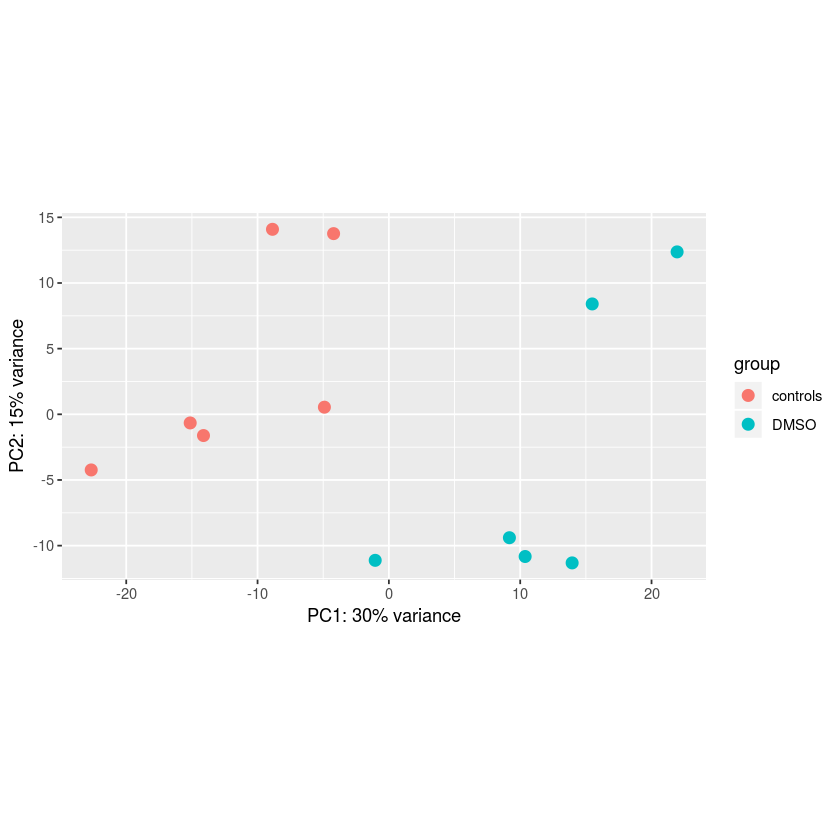

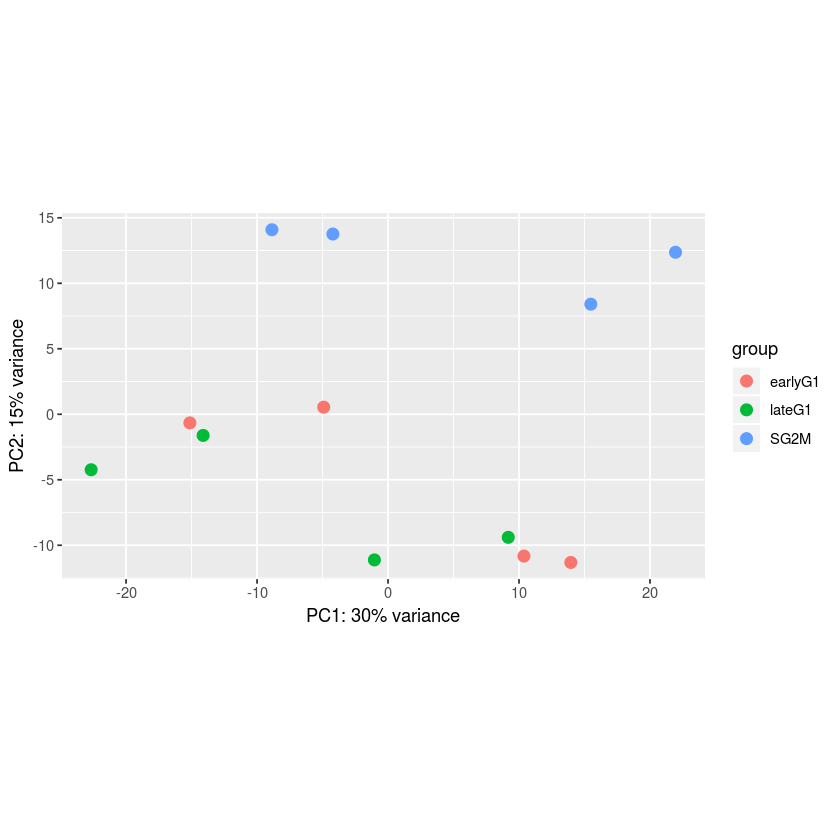

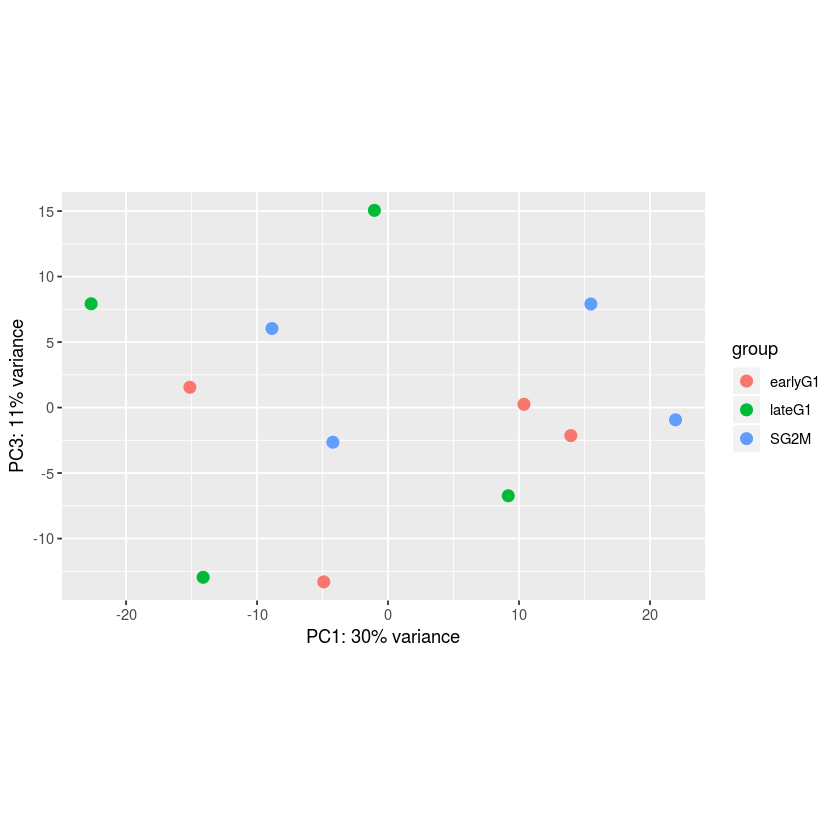

In [7]:
#PCA on vst-transformed data
vst_data=vst(dds)
source('plotPCA_custom.R')
plotPCA_custom(vst_data,intgroup=c("Treatment"),ntop=160698,returnData=FALSE,pcx=1,pcy=2)
plotPCA_custom(vst_data,intgroup=c("CellCycle"),ntop=160698,returnData=FALSE,pcx=1,pcy=2)
plotPCA_custom(vst_data,intgroup=c("CellCycle"),ntop=160698,returnData=FALSE,pcx=1,pcy=3)


In [8]:
#perform size factor estimation for for housekeeping (HK) promoters
hk_promoters=read.table("HK.promoters.txt",header=TRUE,sep='\t')
hk_promoters=paste(hk_promoters$Chrom,hk_promoters$Start,hk_promoters$End,sep="_")
hk_promoter_indices=match(hk_promoters,rownames(data))


In [9]:
dds <- estimateSizeFactors(dds, controlGenes=hk_promoter_indices)


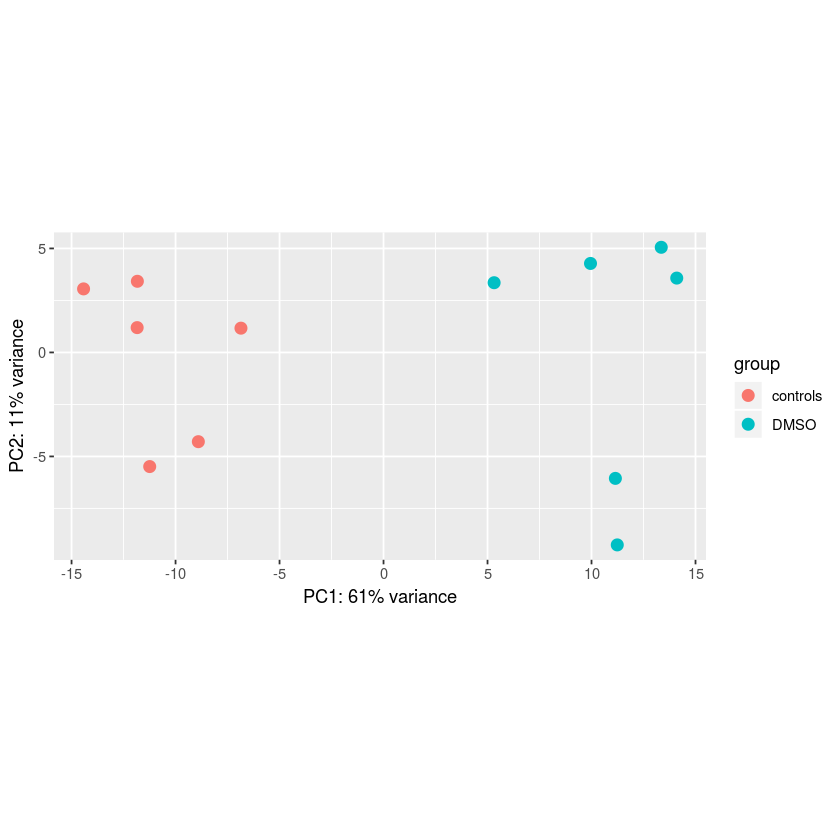

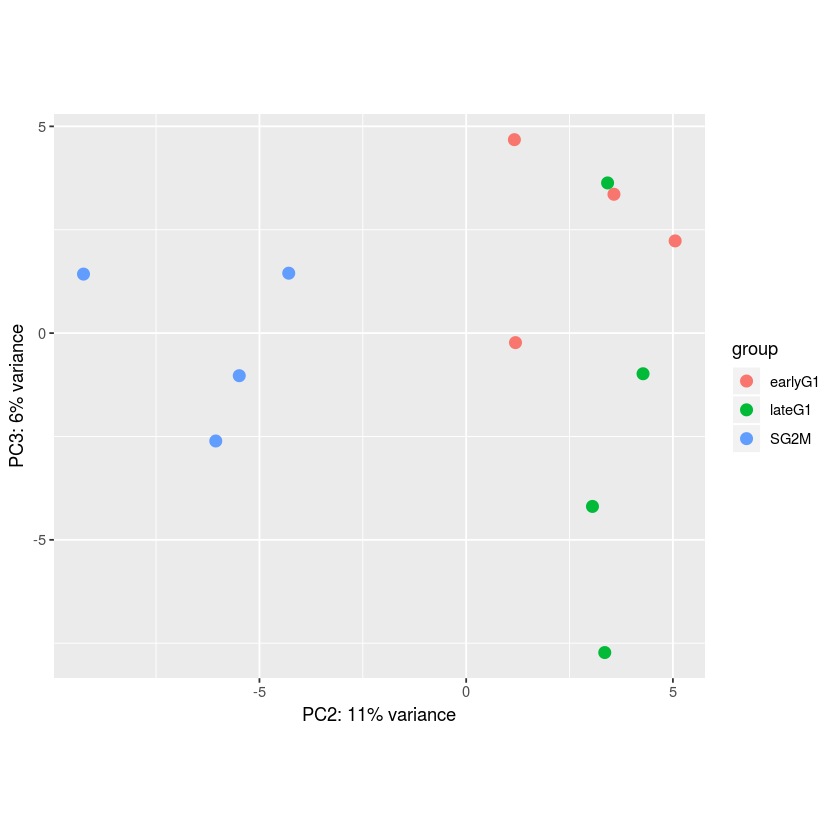

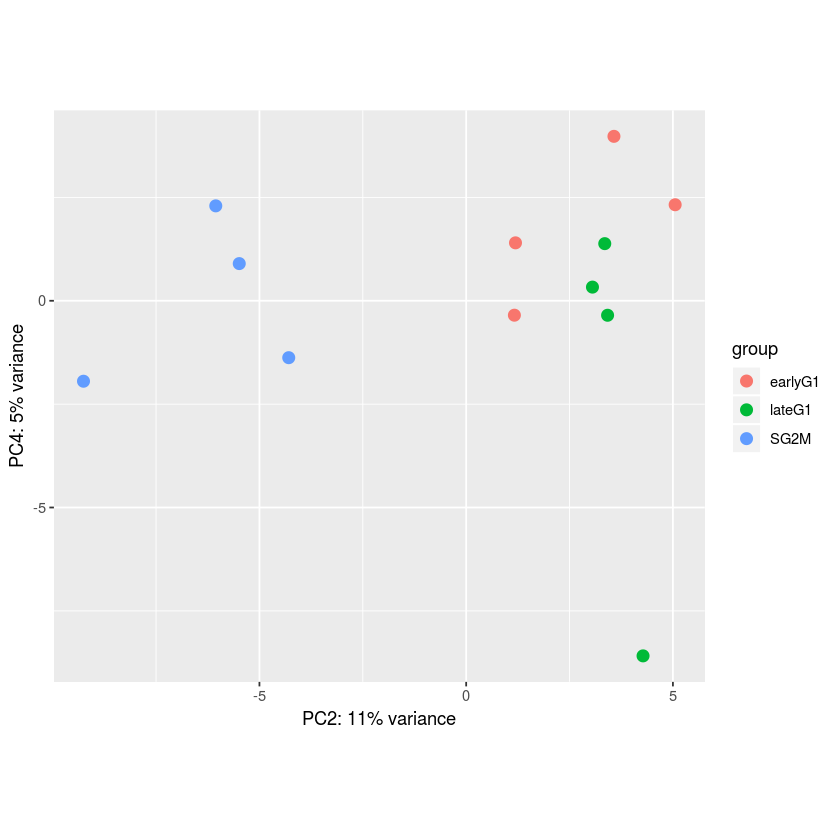

In [10]:
#PCA on vst-transformed data w/ custom sizeFactors
# shifted log of normalized counts
se <- SummarizedExperiment(log2(counts(dds, normalized=TRUE) + 1),
                           colData=colData(dds))
# the call to DESeqTransform() is needed to
# trigger our plotPCA method.
plotPCA_custom( DESeqTransform( se ),intgroup=c("Treatment"),pcx=1,pcy=2)
plotPCA_custom( DESeqTransform( se ),intgroup=c("CellCycle"),pcx=2,pcy=3)
plotPCA_custom( DESeqTransform( se ),intgroup=c("CellCycle"),pcx=2,pcy=4)


## Differential Accessibility Operation

In [11]:
#Run the differential analysis
dds <- DESeq(dds,parallel = FALSE)


using pre-existing size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing


In [12]:
resultsNames(dds)

[1] "Intercept"                      "CellCycle_lateG1_vs_earlyG1"   
[3] "CellCycle_SG2M_vs_earlyG1"      "CellCycleearlyG1.TreatmentDMSO"
[5] "CellCyclelateG1.TreatmentDMSO"  "CellCycleSG2M.TreatmentDMSO"

In [13]:
res=results(dds, independentFiltering=FALSE)
summary(res)


out of 22798 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 9, 0.039%
LFC < 0 (down)     : 15, 0.066%
outliers [1]       : 0, 0%
low counts [2]     : 0, 0%
(mean count < 0)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



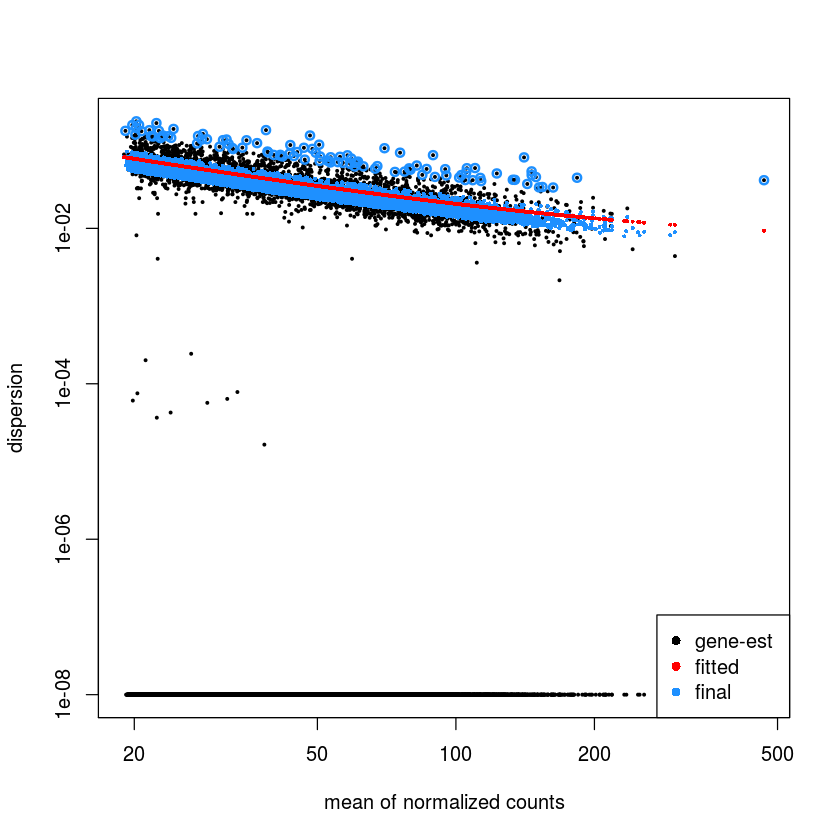

In [14]:
plotDispEsts(dds)


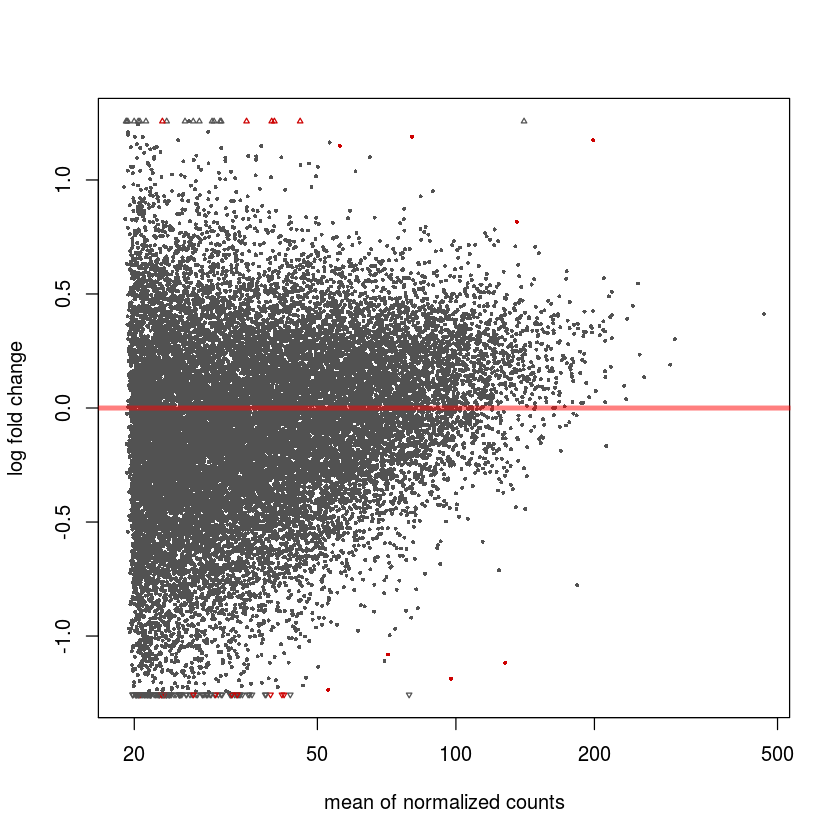

In [15]:
plotMA(res)


## Results

In [16]:
namesToOutput=c("CellCycle_lateG1_vs_earlyG1",
"CellCycle_SG2M_vs_earlyG1",
"CellCycleearlyG1.TreatmentDMSO",
"CellCyclelateG1.TreatmentDMSO",
"CellCycleSG2M.TreatmentDMSO")
numcomparisons=length(namesToOutput)

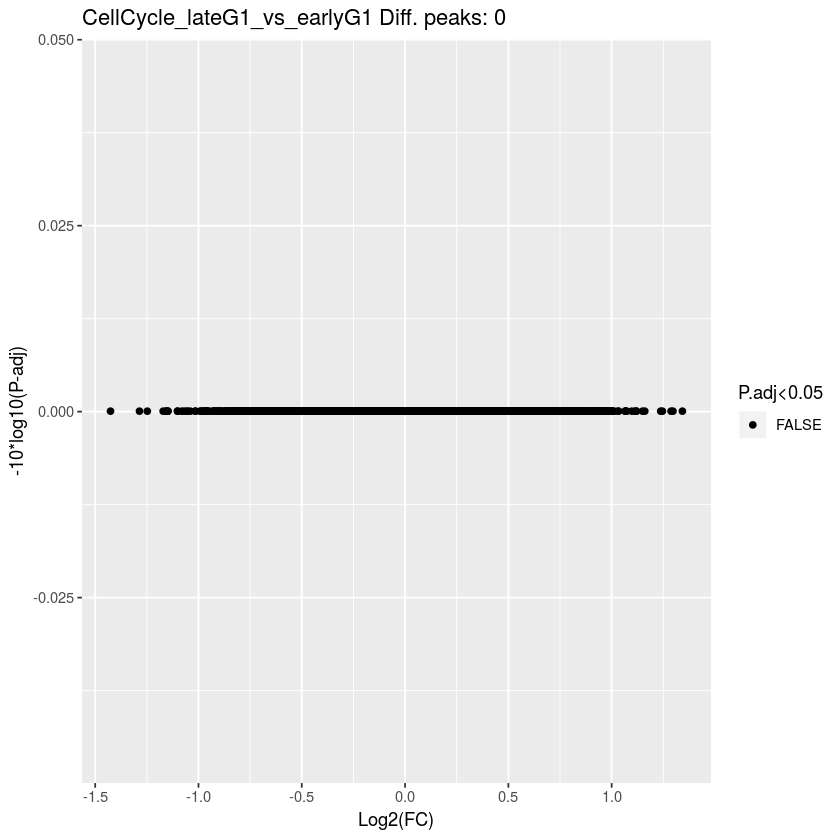

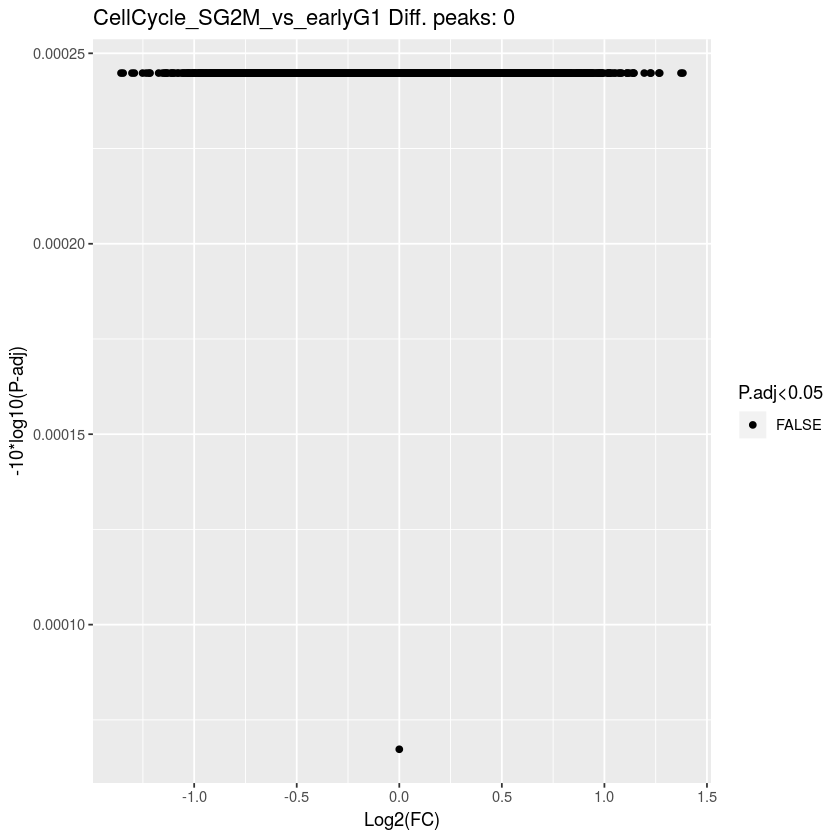

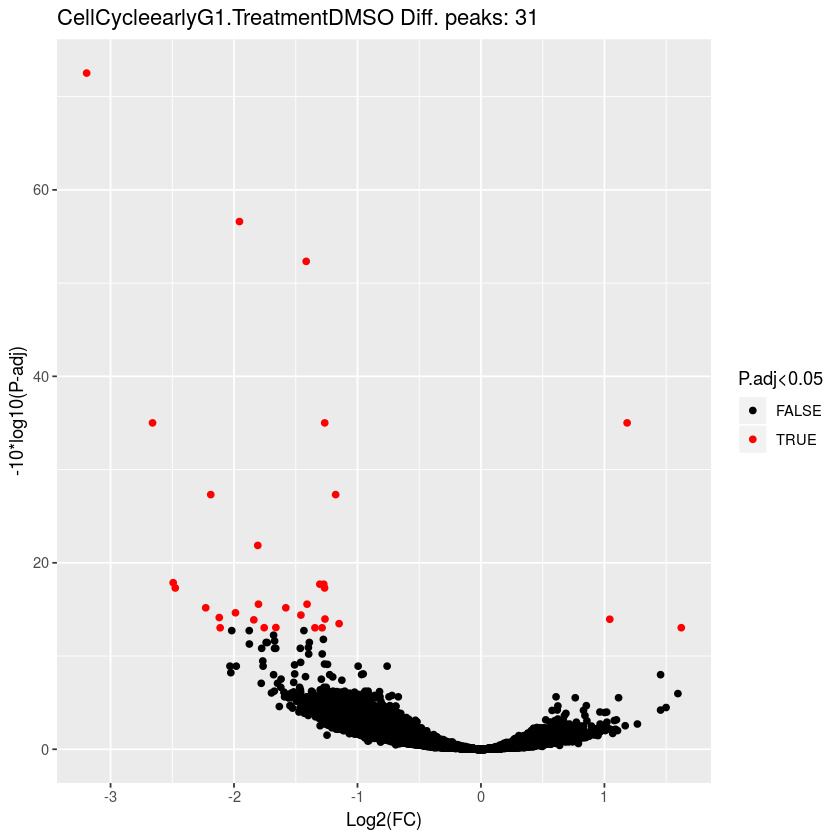

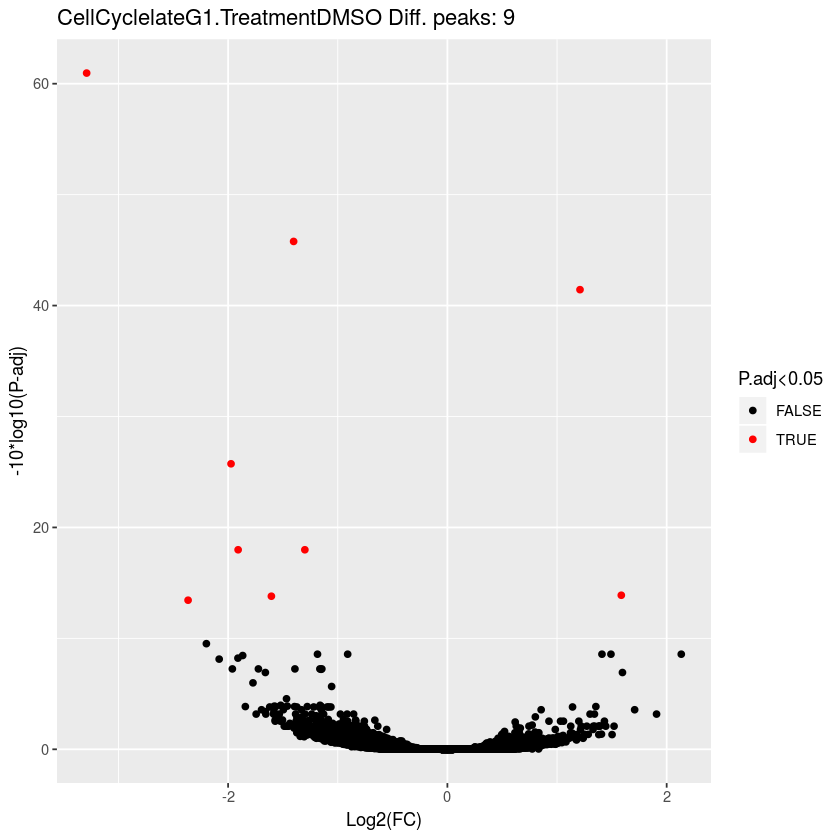

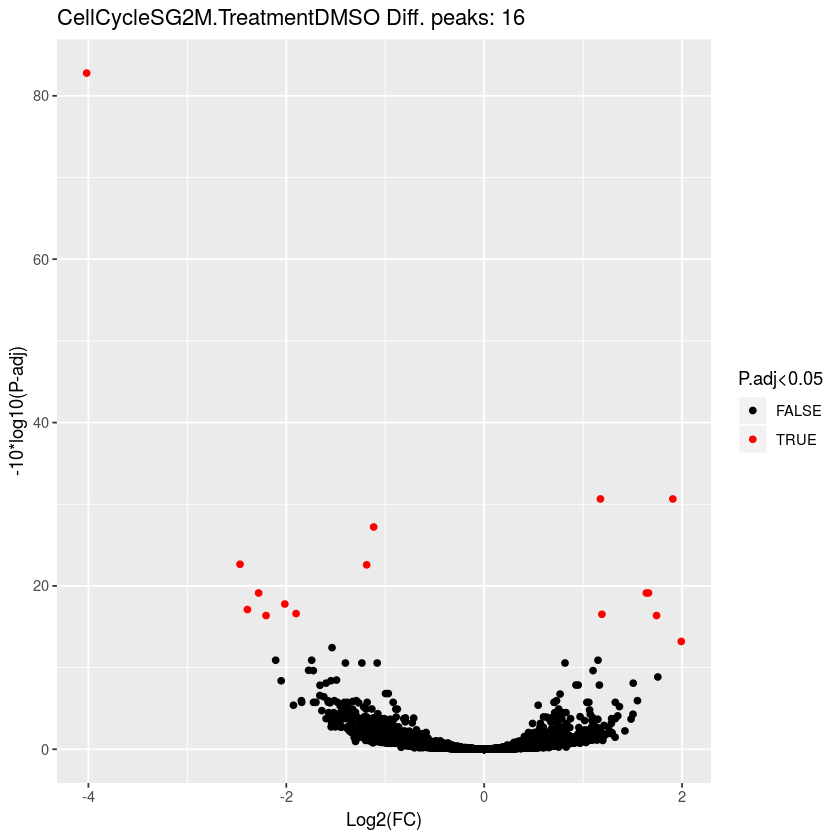

In [17]:
for(i in seq(1,numcomparisons))
{
 res=results(dds,name=namesToOutput[i],parallel=TRUE,independentFiltering = FALSE)
 res$logPadj=-10*log10(res$padj)
 res=as.data.frame(res)
 res=na.omit(res)
 numsig=sum(res$padj <= 0.05)
 sigsubset=res[res$padj<=0.05,]

 #output differential analysis results for the contrast
 #outtable=paste(namesToOutput[i],"tsv",sep='.')
 #write.table(sigsubset,file=outtable,quote=FALSE,sep='\t',row.names=TRUE,col.names=TRUE)
 #print(paste(namesToOutput[i],numsig))

 #generate a volcano plot of the differential analysis for the contrast
 #outpng=paste("volcano",namesToOutput[i],"png",sep='.')
 outlabel=paste(namesToOutput[i],"Diff. peaks:",numsig)
 res$color=res$padj<=0.05

 #png(outpng)#,width=5,height=5,pointsize=12)
 print(ggplot(data=res,
        aes(x=res$log2FoldChange,
            y=res$logPadj,
            color=res$color))+
        geom_point()+
        xlab("Log2(FC)")+
        ylab("-10*log10(P-adj)")+
        ggtitle(outlabel)+
        scale_color_manual(values=c("#000000","#ff0000"),name="P.adj<0.05"))
 #dev.off()
}


In [18]:
res=results(dds,independentFiltering = FALSE)
res$filtRatio=-log10(res$pvalue)/res$baseMean
res_df=as.data.frame(res[order(-res$filtRatio),])

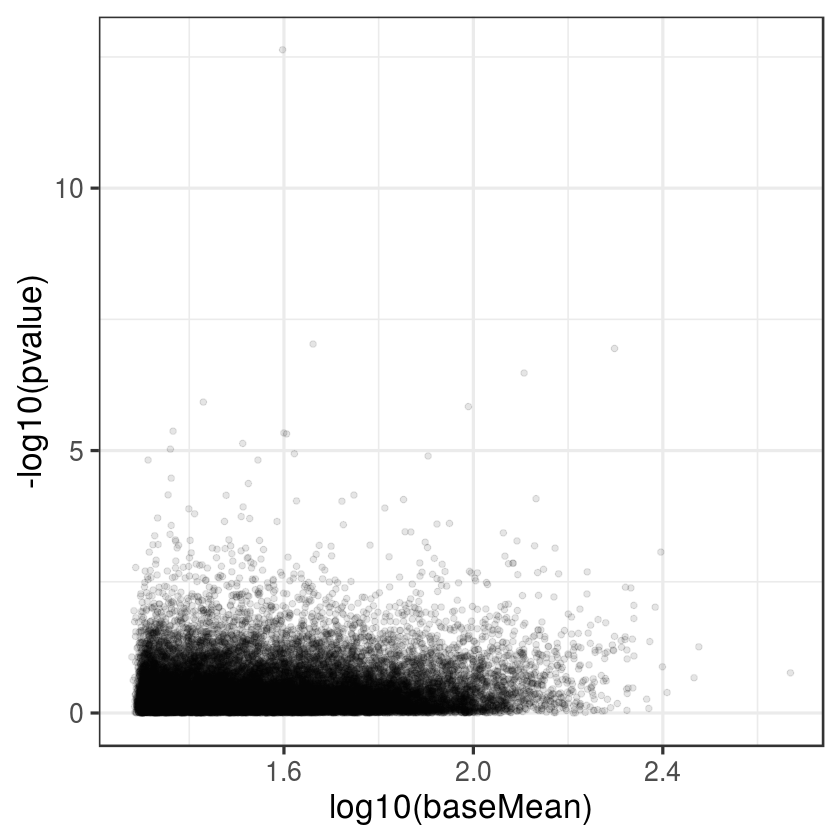

In [19]:
ggplot(data=res_df,
       aes(x=log10(res_df$baseMean),
           y=-log10(res_df$pvalue)))+
       geom_point(alpha=0.1)+
       xlab("log10(baseMean)")+
       ylab("-log10(pvalue)")+
       theme_bw(20)
       
       

## Find an optimal filtering threshold with IHW

In [20]:
library("IHW")
resIHW=results(dds,filterFun=ihw)
summary(resIHW)


out of 22798 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 6, 0.026%
LFC < 0 (down)     : 11, 0.048%
outliers [1]       : 0, 0%
[1] see 'cooksCutoff' argument of ?results
see metadata(res)$ihwResult on hypothesis weighting



In [21]:
sum(resIHW$padj < 0.1, na.rm=TRUE)

[1] 17

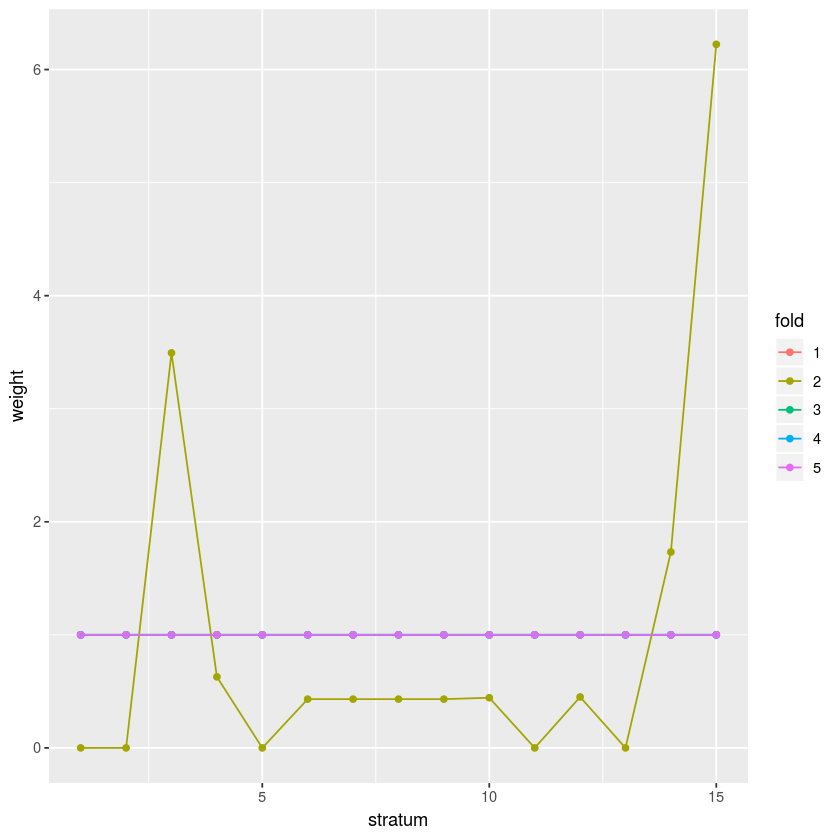

In [22]:
plot(metadata(resIHW)$ihwResult)


In [23]:
metadata(resIHW)$ihwResult



ihwResult object with 22798 hypothesis tests 
Nominal FDR control level: 0.1 
Split into 15 bins, based on an ordinal covariate

In [24]:
resNoFilt <- results(dds, independentFiltering=FALSE)
addmargins(table(filtering=(res$padj < .1),
                 noFiltering=(resNoFilt$padj < .1)))

,FALSE,TRUE,Sum
FALSE,22774,0,22774
TRUE,0,24,24
Sum,22774,24,22798


## plotCounts